# Modeling Pat Adoption with RandomForestClassifier

This notebook will use the Random Trees Algorithm for prediction of pet's adoption speed
- Metrics: Accuracy and Cohen's Weighted Kappa 
- Comparing model performance for cats and dogs combined vs. seperately. We will evaluate the overall accuracy for cats and dogs with 
  acc_combined_model = ((acc_cats * number_cats) + (acc_dogs * number_dogs))/(number_cats + number_dogs)

In [1]:
# importing necessary libraries and dependencies

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report, confusion_matrix

# import custom functions
from custom_functions import our_metrics, get_kappa, model_hyperparams

# display options
pd.set_option('display.max_rows', None)





# Import processed data - Cats and Dogs Combined

In [2]:
# import features
X_train = pd.read_csv('../data/petfinder-adoption-prediction/train/X_train_minmax_scaled_processed.csv')
X_test = pd.read_csv('../data/petfinder-adoption-prediction/train/X_test_minmax_scaled_processed.csv')

# import target
y_train = pd.read_csv('../data/petfinder-adoption-prediction/train/y_train.csv')
y_test = pd.read_csv('../data/petfinder-adoption-prediction/train/y_test.csv')

# turn target df into 1D-array
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()                  

# 

# Random Forest Default Model - Entire Data Set

In [4]:
# instantiate and fit the default RFC on all features
rf_def = RandomForestClassifier()
rf_def.fit(X_train, y_train)

# predict train-target
rf_def_y_train_pred = rf_def.predict(X_train)
# predict test-target
rf_def_y_test_pred = rf_def.predict(X_test)

# Average number of nodes and depths of trees in the forest
n_nodes = []
depths = []

for single_tree in rf_def.estimators_:
    n_nodes.append(single_tree.tree_.node_count)
    depths.append(single_tree.tree_.max_depth)

print('__________________________________')
print(f'Average number of nodes in the forest: {int(np.mean(n_nodes))}')
print('__________________________________')
print(f'Average depth trees in the forest: {int(np.mean(depths))}')
print(' ')
print(' ')

model_hyperparams(rf_def)

__________________________________
Average number of nodes in the forest: 8134
__________________________________
Average depth trees in the forest: 28
 
 


,set hyperparams
bootstrap,True
ccp_alpha,0.0
class_weight,None
criterion,gini
max_depth,None
max_features,sqrt
max_leaf_nodes,None
max_samples,None
min_impurity_decrease,0.0
min_samples_leaf,1


*** Model Evaluation: Predicting Train-Labels ***
Model Metrics and Normalized Confusion Matrix:
_____________________
Accuracy: 0.9904
_____________________
Weighted Quadratic Kappa: 0.9918


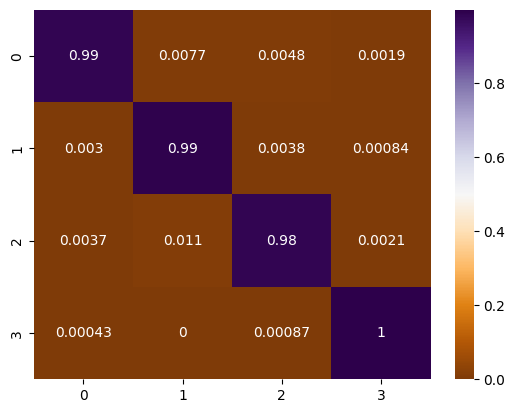

In [ ]:
# Metrics predicting Train-Target
print('*** Model Evaluation: Predicting Train-Labels ***')
our_metrics(y_train, rf_def_y_train_pred)

*** Model Evaluation: Predicting Test-Labels ***
Model Metrics and Normalized Confusion Matrix:
_____________________
Accuracy: 0.371
_____________________
Weighted Quadratic Kappa: 0.2478


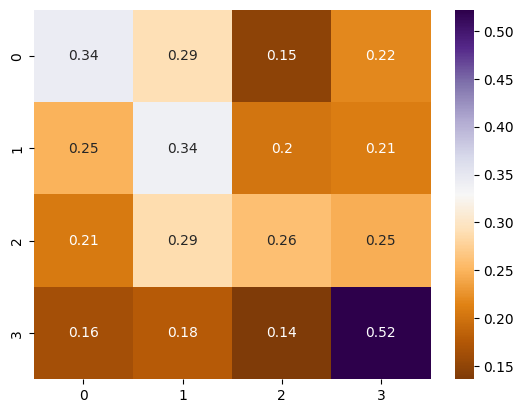

In [ ]:
# Metrics predicting Test-Target
print('*** Model Evaluation: Predicting Test-Labels ***')
our_metrics(y_test, rf_def_y_test_pred)

In [5]:
X_test.columns

Index(['type', 'gender', 'sterilized', 'breed_type', 'vaccinated_dewormed',
       'fee_bin', 'maturitysize_0', 'maturitysize_1', 'maturitysize_2',
       'maturitysize_3', 'furlength_0', 'furlength_1', 'furlength_2',
       'health_0', 'health_1', 'health_2', 'color_pattern_0',
       'color_pattern_1', 'color_pattern_2', 'photoamt_11', 'age_bin',
       'description_char'],
      dtype='object')

# Random Forest Grid Search - Entire Data Set

In [10]:
# Hyperparameter grid based on hyperparameters of the default model:

# setting hyperparameter grid:
param_grid = {
    'n_estimators': [500],
    'max_depth': [None] + list(np.arange(10, 28)),
    'max_features': [None] + list(np.arange(1,5)),
    'min_samples_split': np.linspace(20, 200, 10).astype(int),
    'min_samples_leaf': np.linspace(10, 100, 10).astype(int),
    'bootstrap': [True, False]
}

# Estimator for use in random search
estimator = RandomForestClassifier(random_state = 42)

# Create the random search model for best accuracy_score and 250 fits:
rf_rand_grid = RandomizedSearchCV(estimator, param_grid, n_jobs = -1, 
                        scoring = 'accuracy', cv = 5, 
                        n_iter = 50, verbose = 1, random_state=42)

# Fit best model estimated by random search to train data:
rf_rand_grid.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 10, 11, 12, 13, 14,
                                                      15, 16, 17, 18, 19, 20,
                                                      21, 22, 23, 24, 25, 26,
                                                      27],
                                        'max_features': [None, 1, 2, 3, 4],
                                        'min_samples_leaf': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100]),
                                        'min_samples_split': array([ 20,  40,  60,  80, 100, 120, 140, 160, 180, 200]),
                                        'n_estimators': [500]},
                   random_state=42, scoring='accuracy', verbose=1)

In [11]:
rf_rand_grid.best_params_

{'n_estimators': 500,
 'min_samples_split': 60,
 'min_samples_leaf': 20,
 'max_features': 4,
 'max_depth': 25,
 'bootstrap': False}

In [13]:
# instantiate model with best estimators as found by random search
rf_rgs = rf_rand_grid.best_estimator_

# check if hyperparameters were set correctly
print(rf_rgs.get_params)

# predict train-target
rf_rgs_y_train_pred = rf_rgs.predict(X_train)
# predict test-target
rf_rgs_y_test_pred = rf_rgs.predict(X_test)

# Average number of nodes and depths of trees in the forest
n_nodes = []
depths = []

for single_tree in rf_rgs.estimators_:
    n_nodes.append(single_tree.tree_.node_count)
    depths.append(single_tree.tree_.max_depth)

print('__________________________________')
print(f'Average number of nodes in the forest: {int(np.mean(n_nodes))}')
print('__________________________________')
print(f'Average depth trees in the forest: {int(np.mean(depths))}')
print(' ')
print(' ')

model_hyperparams(rf_rgs)

<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=False, max_depth=25, max_features=4,
                       min_samples_leaf=20, min_samples_split=60,
                       n_estimators=500, random_state=42)>
__________________________________
Average number of nodes in the forest: 357
__________________________________
Average depth trees in the forest: 14
 
 


,set hyperparams
bootstrap,False
ccp_alpha,0.0
class_weight,None
criterion,gini
max_depth,25
max_features,4
max_leaf_nodes,None
max_samples,None
min_impurity_decrease,0.0
min_samples_leaf,20


*** Model Evaluation: Predicting Train-Labels ***
Model Metrics and Normalized Confusion Matrix:
_____________________
Accuracy: 0.4869
_____________________
Weighted Quadratic Kappa: 0.4018


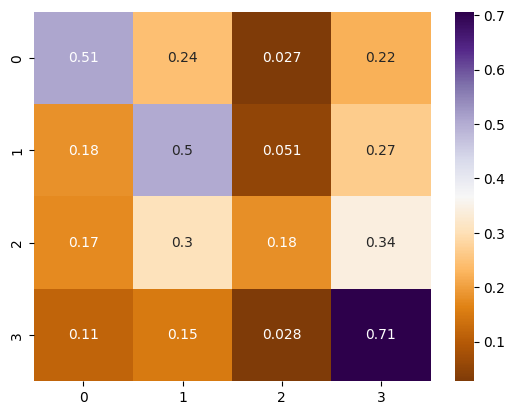

In [14]:
# Metrics predicting Train-Target
print('*** Model Evaluation: Predicting Train-Labels ***')
our_metrics(y_train, rf_rgs_y_train_pred)

*** Model Evaluation: Predicting Test-Labels ***
Model Metrics and Normalized Confusion Matrix:
_____________________
Accuracy: 0.4118
_____________________
Weighted Quadratic Kappa: 0.3378


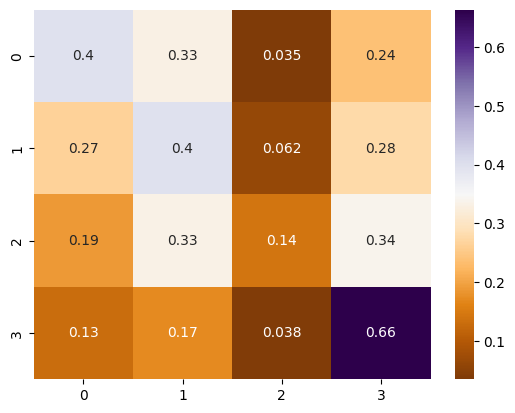

In [15]:
# Metrics predicting Train-Target
print('*** Model Evaluation: Predicting Test-Labels ***')
our_metrics(y_test, rf_rgs_y_test_pred)

# Feature Importance

In [ ]:
features = X_train.columns.tolist()

# data frame with feature names and feature importance scores, sorted by importance
feature_importance = pd.DataFrame({'feature': features,
                   'importance': best_rs_model.feature_importances_}).\
                    sort_values('importance', ascending = False)
# show 10 most important features
feature_importance.head(10)

NameError: name 'best_rs_model' is not defined